# ImageJ in Python

This notebook shows how to use ImageJ as a Python library and uses the OMERO Python API to connect to an OMERO server.

In this setup, Fiji has already been installed. 
We will use the [pyimagej](https://pypi.org/project/pyimagej/) library to access to the entire ImageJ API from Python.

## Packages

In [1]:
import numpy

import imagej
from omero.gateway import BlitzGateway

## Starting ImageJ from Python

To run the macro, we use ImageJ1 windows so it requires using ImageJ in GUI mode and requires handling the resulting windows. This is the reason the parameter `headless` is set to `False`.

You will also need to start the **[desktop](../../desktop)** if it is not already up.
The link should open in a different window. If you see an error message try refreshing the window.

If you do not run the macro, you do **not** need the desktop and do **not** need to set the `headless` (default is `True`).



In [2]:
ij = imagej.init('/srv/conda/vnc/Fiji.app', headless=False)
ij.getVersion()

'2.0.0-rc-69/1.52p'

## Connect to IDR

In [3]:
def connect(hostname, username, password):
    """
    Connect to an OMERO server
    :param hostname: Host name
    :param username: User
    :param password: Password
    :return: Connected BlitzGateway
    """
    conn = BlitzGateway(username, password,
                        host=hostname, secure=True)
    conn.connect()
    conn.c.enableKeepAlive(60)
    return conn

conn = connect("ws://idr.openmicroscopy.org/omero-ws", "public", "public")
print("Connected as {}".format(conn.getUser().getName()))

Connected as public


## Load an image from IDR 

In [4]:
image_id = 1884835
image = conn.getObject("Image", image_id)

## Load binary data from IDR

We load a plane as a 2D numpy. Using the Python API, allows us to load easily only the plane we need.

In [5]:
def load_numpy_array(image):
    pixels = image.getPrimaryPixels()
    return pixels.getPlane(0, 0, 0)

img = load_numpy_array(image)
print(img.shape)

(256, 256)


## Display image using `ij.py.show()`

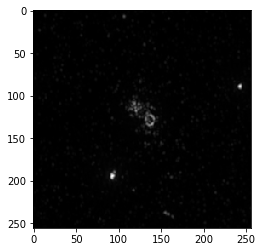

In [6]:
ij.py.show(img[:, :], cmap = 'gray')

## Process numpy arrays in ImageJ

We use the method `to_java()` to convert into ImageJ types.

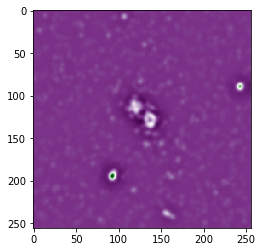

In [7]:
result = numpy.zeros(img.shape)
sigma1 = 8
sigma2 = 2
# note the use of to_java on img and result to turn the numpy images into RAIs
ij.op().filter().dog(
    ij.py.to_java(result),
    ij.py.to_java(img),
    sigma1,
    sigma2)
# purple highlights the edges of the vessels, green highlights the centers
ij.py.show(result, cmap = 'PRGn')

## Run macro

Run a macro on the image. We use ImageJ1 windows so it requires using ImageJ in GUI mode and requires handling the resulting windows.

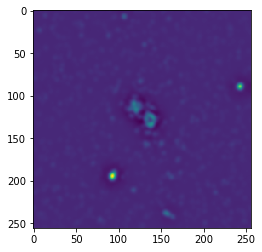

In [8]:
from jnius import autoclass
WindowManager = autoclass('ij.WindowManager')

ij.ui().show('Image', ij.py.to_java(img))
macro = """
run("8-bit");
"""
ij.py.run_macro(macro)

img = WindowManager.getCurrentImage()
img.changes = False
ij.py.show(result)

## Close the connection to IDR

In [9]:
conn.close()

### License (BSD 2-Clause)
Copyright (c) 2021, University of Dundee All rights reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. 